# Búsqueda de Hiperparámetros con XGBoost classifier

Este notebook realiza la búsqueda de hiperparámetros para un modelo usando XGBoost con las siguientes características:

- Carga de datos de entrenamiento desde archivos CSV
- Balanceo del conjunto de datos mediante undersampling
- Búsqueda de hiperparámetros con Grid Search
- Validación cruzada para evaluación robusta
- División balanceada para validación (15% del conjunto de entrenamiento)
- Visualización de métricas de regresión para los mejores modelos

**Autor:** ML Engineer  
**Fecha:** 5 de Septiembre, 2025

## 1. Importar Librerías Requeridas

Importar todas las librerías necesarias para el análisis, modelado y visualización.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import (
    GridSearchCV, 
    train_test_split, 
    cross_val_score, 
    StratifiedShuffleSplit
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

from sklearn.preprocessing import LabelBinarizer
from imblearn.under_sampling import RandomUnderSampler
import joblib
from datetime import datetime
import xgboost as xgb

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✓ Librerías importadas exitosamente!")
print(f"Pandas versión: {pd.__version__}")
print(f"NumPy versión: {np.__version__}")
print(f"Scikit-learn disponible para GridSearchCV y LinearSVR")

✓ Librerías importadas exitosamente!
Pandas versión: 2.3.2
NumPy versión: 2.3.2
Scikit-learn disponible para GridSearchCV y LinearSVR


## 2. Cargar Datos de Entrenamiento

Cargar las características y variables objetivo desde los archivos CSV generados en el proceso de preparación de datos.

In [2]:
# Definir rutas de los archivos
X_train_path = '../data/train/X_train.csv'
y_train_path = '../data/train/y_train.csv'

print("CARGA DE DATOS DE ENTRENAMIENTO")
print("=" * 50)

# Cargar características (X_train)
try:
    X_train_full = pd.read_csv(X_train_path)
    print(f"✓ Características cargadas desde: {X_train_path}")
    print(f"  • Forma: {X_train_full.shape}")
    print(f"  • Características: {X_train_full.shape[1]}")
except FileNotFoundError:
    raise FileNotFoundError(f"Archivo no encontrado: {X_train_path}")

# Cargar variable objetivo (y_train)
try:
    y_train_full = pd.read_csv(y_train_path)
    # Si es un DataFrame con una columna, convertir a Series
    if isinstance(y_train_full, pd.DataFrame):
        y_train_full = y_train_full.iloc[:, 0]
    print(f"✓ Variable objetivo cargada desde: {y_train_path}")
    print(f"  • Forma: {y_train_full.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"Archivo no encontrado: {y_train_path}")

print(f"\n✓ Datos cargados exitosamente!")
print(f"Total de registros: {len(X_train_full):,}")

CARGA DE DATOS DE ENTRENAMIENTO
✓ Características cargadas desde: ../data/train/X_train.csv
  • Forma: (91199, 18)
  • Características: 18
✓ Variable objetivo cargada desde: ../data/train/y_train.csv
  • Forma: (91199,)

✓ Datos cargados exitosamente!
Total de registros: 91,199


In [3]:
# Codificar la variable objetivo para que sea binaria.
# Asumimos que la clase positiva es '1' y la negativa es '0'.
# Si el valor de la variable objetivo es menor a 30, se considera como 0 (no popular),
# y si es mayor o igual a 300, se considera como 1 (popular).
y_train_full = (y_train_full >= 30).astype(int)
print("✓ Variable objetivo codificada como binaria (0: no popular, 1: popular)")
print(y_train_full.value_counts())

✓ Variable objetivo codificada como binaria (0: no popular, 1: popular)
popularity
1    50906
0    40293
Name: count, dtype: int64


## 3. División de datos para Validación

Crear una división balanceada del 15% del conjunto de entrenamiento para validación final.

In [5]:
# División balanceada para validación (15% del dataset balanceado)
print("DIVISIÓN BALANCEADA PARA VALIDACIÓN")
print("=" * 50)

validation_size = 0.15

# Usar StratifiedShuffleSplit para mantener el balanceo
#splitter = StratifiedShuffleSplit(
#    n_splits=1, 
#    test_size=validation_size, 
#    random_state=42
#)

# Realizar la división
#train_idx, val_idx = next(splitter.split(X_train_full, y_train_full))

#X_train = X_train_full.iloc[train_idx]
#X_val = X_train_full.iloc[val_idx]
#y_train = y_train_full.iloc[train_idx]
#y_val = y_train_full.iloc[val_idx]

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=validation_size, random_state=42, shuffle=True)

print(f"División completada:")
print(f"  • Conjunto de entrenamiento: {len(X_train):,} registros ({(1-validation_size)*100:.0f}%)")
print(f"  • Conjunto de validación: {len(X_val):,} registros ({validation_size*100:.0f}%)")

print(f"\nBalanceo en conjunto de validación:")
val_dist = y_val.value_counts().sort_index()
for value, count in val_dist.items():
    print(f"  • Clase {value}: {count:,} registros ({count/len(y_val)*100:.1f}%)")

print(f"\n✓ División balanceada completada exitosamente!")

DIVISIÓN BALANCEADA PARA VALIDACIÓN
División completada:
  • Conjunto de entrenamiento: 77,519 registros (85%)
  • Conjunto de validación: 13,680 registros (15%)

Balanceo en conjunto de validación:
  • Clase 0: 6,034 registros (44.1%)
  • Clase 1: 7,646 registros (55.9%)

✓ División balanceada completada exitosamente!


## 4. Configuración de Búsqueda de Hiperparámetros

Definir la grilla de hiperparámetros y configurar GridSearchCV para LinearSVR.

In [6]:
# Configuración de la grilla de hiperparámetros para XgBoost
print("CONFIGURACIÓN DE GRILLA DE HIPERPARÁMETROS")
print("=" * 50)

# Definir la grilla de hiperparámetros
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

print(f"Grilla de hiperparámetros definida:")
total_combinations = 1
for param, values in param_grid.items():
    print(f"  • {param}: {values}")
    total_combinations *= len(values)

print(f"\nTotal de combinaciones: {total_combinations:,}")

# Configurar validación cruzada
cv_folds = 5
print(f"Validación cruzada: {cv_folds} folds")
print(f"Total de entrenamientos: {total_combinations * cv_folds:,}")

CONFIGURACIÓN DE GRILLA DE HIPERPARÁMETROS
Grilla de hiperparámetros definida:
  • learning_rate: [0.01, 0.1, 0.2, 0.3]
  • max_depth: [3, 5, 7, 9]
  • min_child_weight: [1, 3, 5]
  • subsample: [0.6, 0.8, 1.0]
  • colsample_bytree: [0.6, 0.8, 1.0]
  • n_estimators: [100, 200, 300]

Total de combinaciones: 1,296
Validación cruzada: 5 folds
Total de entrenamientos: 6,480


In [ ]:
# Configurar GridSearchCV
print("CONFIGURACIÓN DE GRIDSEARCHCV")
print("=" * 50)

# Crear el modelo base
xgb_model = xgb.XGBClassifier()

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=cv_folds,
    scoring='f1',  # Métrica principal para optimización
    n_jobs=-1,  # Usar todos los cores disponibles
    verbose=1,  # Mostrar progreso
    return_train_score=True
)

print(f"✓ GridSearchCV configurado:")
print(f"  • Estimador: XGBoost Classifier")
print(f"  • Métrica de scoring: f1")
print(f"  • Folds de CV: {cv_folds}")
print(f"  • Paralelización: Todos los cores disponibles")
print(f"  • Total de evaluaciones: {total_combinations * cv_folds:,}")

print(f"\n🚀 Listo para ejecutar búsqueda de hiperparámetros...")

CONFIGURACIÓN DE GRIDSEARCHCV
✓ GridSearchCV configurado:
  • Estimador: XGBoost Classifier
  • Métrica de scoring: f1
  • Folds de CV: 5
  • Paralelización: Todos los cores disponibles
  • Total de evaluaciones: 6,480

🚀 Listo para ejecutar búsqueda de hiperparámetros...


## 5. Ejecución de Búsqueda de Hiperparámetros

Ejecutar GridSearchCV para encontrar los mejores hiperparámetros.

In [8]:
# Ejecutar búsqueda de hiperparámetros
print("🔍 INICIANDO BÚSQUEDA DE HIPERPARÁMETROS")
print("=" * 50)
print(f"Inicio: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Esto puede tomar varios minutos...\n")

# Ejecutar grid search
start_time = datetime.now()
grid_search.fit(X_train, y_train)
end_time = datetime.now()

duration = end_time - start_time
print(f"\n✓ Búsqueda de hiperparámetros completada!")
print(f"Tiempo total: {duration}")
print(f"Fin: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")

🔍 INICIANDO BÚSQUEDA DE HIPERPARÁMETROS
Inicio: 2025-09-06 16:17:11
Esto puede tomar varios minutos...

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits

✓ Búsqueda de hiperparámetros completada!
Tiempo total: 0:14:06.071128
Fin: 2025-09-06 16:31:17


In [9]:
# Analizar resultados de la búsqueda
print("RESULTADOS DE LA BÚSQUEDA DE HIPERPARÁMETROS")
print("=" * 50)

# Mejores hiperparámetros
print(f"Mejores hiperparámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  • {param}: {value}")

print(f"\nMejor score (CV): {grid_search.best_score_:.6f} (F1)")

# Obtener el mejor modelo
best_model = grid_search.best_estimator_
print(f"\n✓ Mejor modelo obtenido y listo para evaluación")

RESULTADOS DE LA BÚSQUEDA DE HIPERPARÁMETROS
Mejores hiperparámetros encontrados:
  • colsample_bytree: 0.6
  • learning_rate: 0.3
  • max_depth: 9
  • min_child_weight: 1
  • n_estimators: 300
  • subsample: 1.0

Mejor score (CV): 0.854243 (F1)

✓ Mejor modelo obtenido y listo para evaluación


## 7. Análisis de los Top 3 Modelos

Analizar y comparar las métricas de los 3 mejores modelos encontrados.

In [10]:
# Obtener los top 3 modelos
print("ANÁLISIS DE LOS TOP 3 MODELOS")
print("=" * 50)

# Crear DataFrame con todos los resultados
results_df = pd.DataFrame(grid_search.cv_results_)

# Ordenar por mejor score y obtener top 3
top_3_results = results_df.nlargest(3, 'mean_test_score')

print(f"Top 3 configuraciones de hiperparámetros:")
print("=" * 40)

top_3_models = []
top_3_params = []

for i, (idx, row) in enumerate(top_3_results.iterrows(), 1):
    params = row['params']
    score = row['mean_test_score']
    std = row['std_test_score']
    
    print(f"\nModelo #{i}:")
    print(f"  F1 Score: {score:.6f} (±{std:.6f})")
    print(f"  Parámetros: {params}")
    
    # Crear y entrenar el modelo con estos parámetros
    model = xgb.XGBClassifier(random_state=42, **params)
    model.fit(X_train, y_train)
    top_3_models.append(model)
    top_3_params.append(params)

print(f"\n✓ Top 3 modelos entrenados y listos para evaluación")

ANÁLISIS DE LOS TOP 3 MODELOS
Top 3 configuraciones de hiperparámetros:

Modelo #1:
  F1 Score: 0.854243 (±0.001965)
  Parámetros: {'colsample_bytree': 0.6, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}

Modelo #2:
  F1 Score: 0.853100 (±0.001562)
  Parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}

Modelo #3:
  F1 Score: 0.853013 (±0.002070)
  Parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}

✓ Top 3 modelos entrenados y listos para evaluación


## 8. Evaluación de Métricas de Clasificación

Calcular y comparar métricas de clasificación para los top 3 modelos en el conjunto de validación.

In [11]:
# Calcular métricas para los top 3 modelos
print("EVALUACIÓN DE MÉTRICAS EN CONJUNTO DE VALIDACIÓN")
print("=" * 50)

metrics_results = []

for i, model in enumerate(top_3_models, 1):
    # Predicciones en conjunto de validación
    y_pred = model.predict(X_val)
    
    # Calcular métricas de clasificación
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred)
    
    # Para accuracy, convertir predicciones a clases binarias
    y_pred_binary = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)
    
    # Guardar resultados
    metrics = {
        'Modelo': f'Modelo #{i}',
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Accuracy': accuracy,
        'Parámetros': str(top_3_params[i-1])
    }
    metrics_results.append(metrics)
    
    print(f"\nModelo #{i} - Métricas en Validación:")
    print(f"  • Precision: {precision:.6f}")
    print(f"  • Recall: {recall:.6f}")
    print(f"  • F1 Score: {f1:.6f}")
    print(f"  • ROC AUC: {roc_auc:.6f}")
    print(f"  • Accuracy: {accuracy:.6f}")

# Crear DataFrame con todas las métricas
metrics_df = pd.DataFrame(metrics_results)
print(f"\n✓ Métricas calculadas para todos los modelos")

EVALUACIÓN DE MÉTRICAS EN CONJUNTO DE VALIDACIÓN

Modelo #1 - Métricas en Validación:
  • Precision: 0.852087
  • Recall: 0.859665
  • F1 Score: 0.855859
  • ROC AUC: 0.835285
  • Accuracy: 0.838158

Modelo #2 - Métricas en Validación:
  • Precision: 0.848765
  • Recall: 0.863196
  • F1 Score: 0.855920
  • ROC AUC: 0.834150
  • Accuracy: 0.837573

Modelo #3 - Métricas en Validación:
  • Precision: 0.853769
  • Recall: 0.860581
  • F1 Score: 0.857161
  • ROC AUC: 0.836903
  • Accuracy: 0.839693

✓ Métricas calculadas para todos los modelos


## 9. Visualización de Métricas de Clasificación

Crear gráficos comparativos de las métricas de clasificación para los top 3 modelos.

CREANDO VISUALIZACIONES DE MÉTRICAS


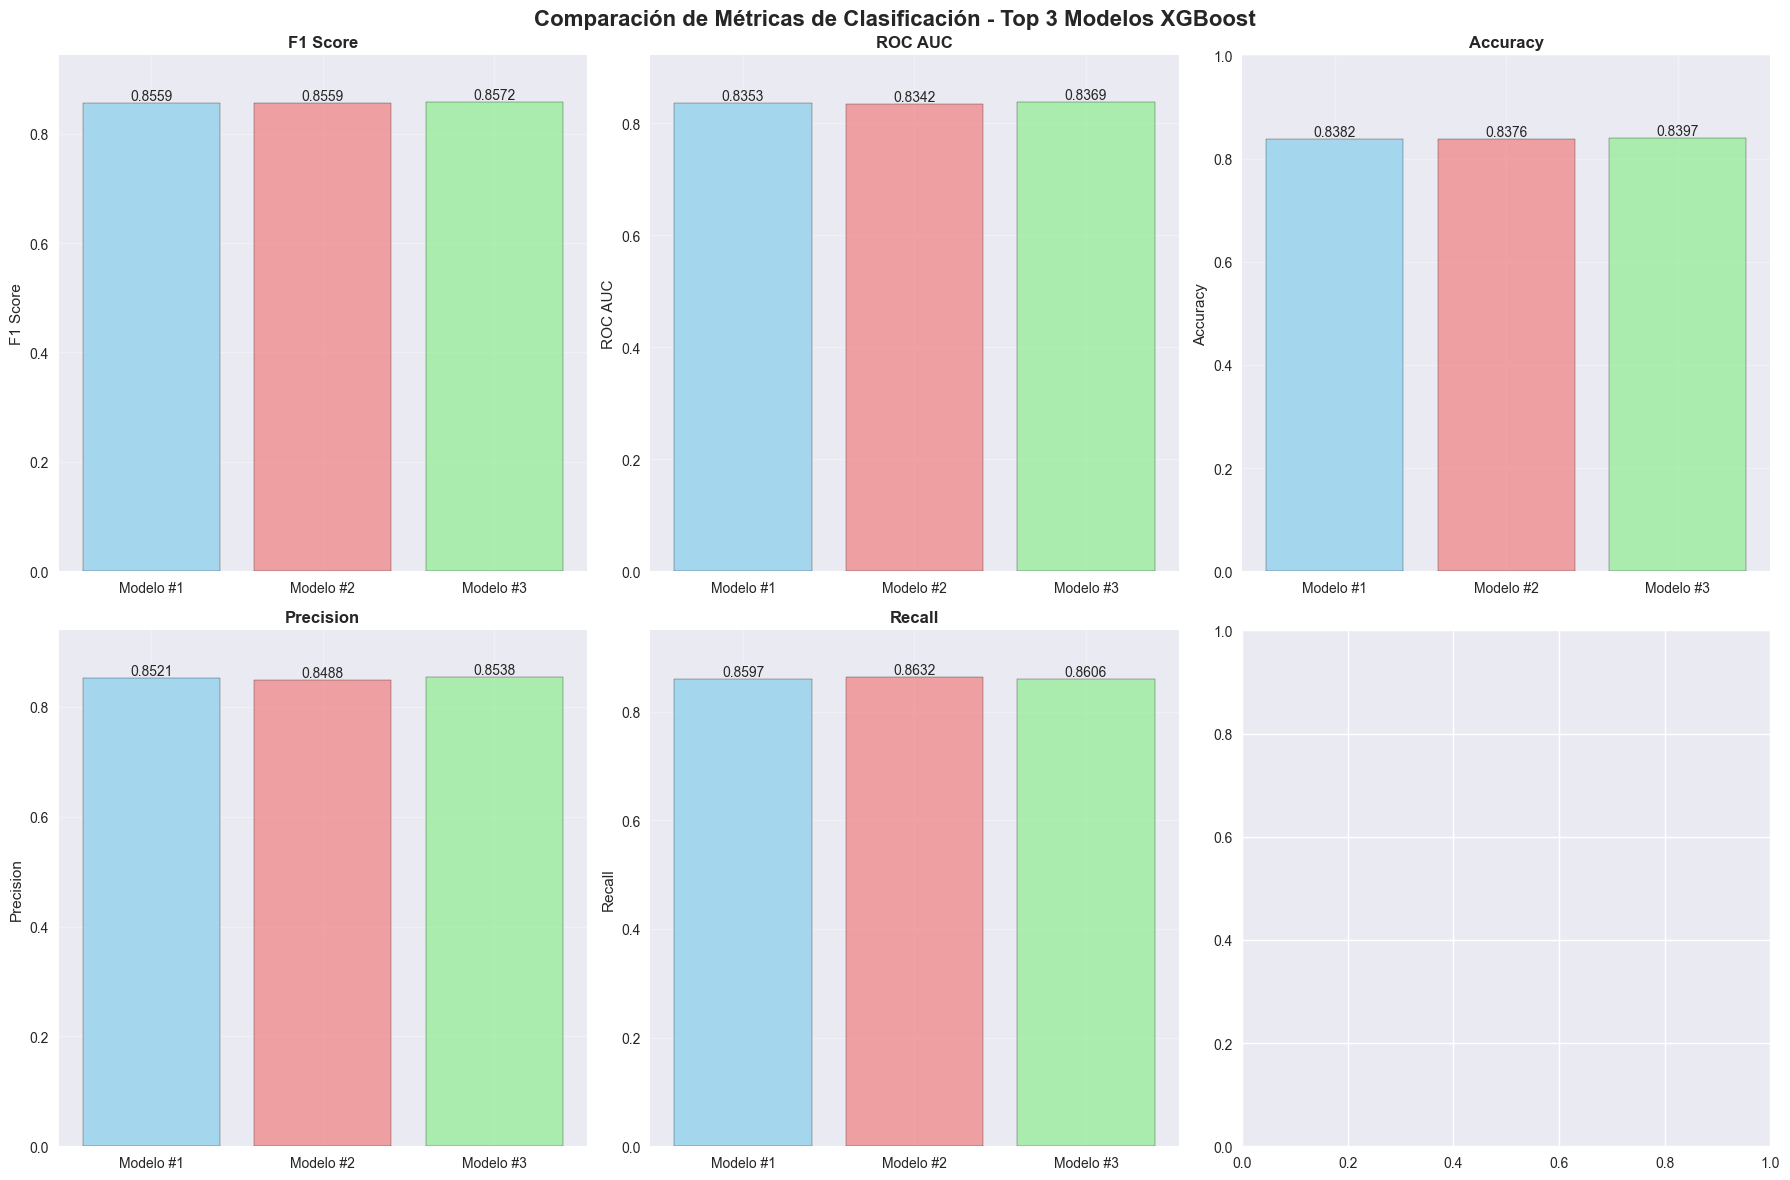

✓ Visualizaciones creadas exitosamente


In [12]:
# Crear visualizaciones de las métricas
print("CREANDO VISUALIZACIONES DE MÉTRICAS")
print("=" * 50)

# Configurar el tamaño de la figura
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparación de Métricas de Clasificación - Top 3 Modelos XGBoost', 
             fontsize=16, fontweight='bold')

# Definir métricas para visualizar
metrics_to_plot = ['F1 Score', 'ROC AUC', 'Accuracy', 'Precision', 'Recall']
colors = ['skyblue', 'lightcoral', 'lightgreen']

# Crear gráfico para cada métrica
for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Extraer valores de la métrica
    values = [metrics_results[i][metric] for i in range(3)]
    models = [f'Modelo #{i+1}' for i in range(3)]
    
    # Crear gráfico de barras
    bars = ax.bar(models, values, color=colors, alpha=0.7, edgecolor='black')
    
    # Configurar el gráfico
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)
    
    # Añadir valores en las barras
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}', ha='center', va='bottom', fontsize=10)
    
    # Ajustar límites para mejor visualización
    if metric in ['R²', 'Explained Variance', 'Accuracy']:
        ax.set_ylim(0, 1)
    else:
        ax.set_ylim(0, max(values) * 1.1)

plt.tight_layout()
plt.show()

print("✓ Visualizaciones creadas exitosamente")

In [13]:
# Crear tabla comparativa de métricas
print("TABLA COMPARATIVA DE MÉTRICAS")
print("=" * 50)

# Mostrar tabla con métricas

display_df = metrics_df[['Modelo', 'F1 Score', 'ROC AUC', 'Accuracy', 'Precision', 'Recall']].copy()

# Formatear números para mejor lectura
for col in ['F1 Score', 'ROC AUC', 'Accuracy', 'Precision', 'Recall']:
    display_df[col] = display_df[col].round(6)

print("Resumen de métricas para los top 3 modelos:")
display(display_df)

# Identificar el mejor modelo para cada métrica
print("\nMejor modelo por métrica:")
print("-" * 30)
for metric in ['F1 Score', 'ROC AUC', 'Accuracy', 'Precision', 'Recall']:
    if metric in ['F1 Score', 'ROC AUC', 'Accuracy', 'Precision', 'Recall']:  # Mayor es mejor
        best_idx = display_df[metric].idxmax()
    else:  # Menor es mejor
        best_idx = display_df[metric].idxmin()
    
    best_model = display_df.loc[best_idx, 'Modelo']
    best_value = display_df.loc[best_idx, metric]
    print(f"• {metric}: {best_model} ({best_value:.6f})")

TABLA COMPARATIVA DE MÉTRICAS
Resumen de métricas para los top 3 modelos:


,Modelo,F1 Score,ROC AUC,Accuracy,Precision,Recall
0,Modelo #1,0.855859,0.835285,0.838158,0.852087,0.859665
1,Modelo #2,0.855920,0.834150,0.837573,0.848765,0.863196
2,Modelo #3,0.857161,0.836903,0.839693,0.853769,0.860581



Mejor modelo por métrica:
------------------------------
• F1 Score: Modelo #3 (0.857161)
• ROC AUC: Modelo #3 (0.836903)
• Accuracy: Modelo #3 (0.839693)
• Precision: Modelo #3 (0.853769)
• Recall: Modelo #2 (0.863196)


## 10. Análisis de Validación Cruzada

Realizar validación cruzada adicional en el mejor modelo para verificar su robustez.

In [14]:
# Validación cruzada del mejor modelo
print("VALIDACIÓN CRUZADA DEL MEJOR MODELO")
print("=" * 50)

best_model = top_3_models[0]  # El primer modelo ya es el mejor

# Definir métricas para validación cruzada
cv_metrics = {
    'f1': 'F1 Score',
    'roc_auc': 'ROC AUC',
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall'
}

cv_results = {}

for scoring, metric_name in cv_metrics.items():
    scores = cross_val_score(best_model, X_train, y_train, 
                           cv=cv_folds, scoring=scoring)
    
    # Para métricas negativas, convertir a positivas
    if 'neg_' in scoring:
        scores = -scores
    
    cv_results[metric_name] = scores
    
    print(f"{metric_name}:")
    print(f"  • Media: {scores.mean():.6f}")
    print(f"  • Desviación estándar: {scores.std():.6f}")
    print(f"  • Rango: [{scores.min():.6f}, {scores.max():.6f}]")
    print()

print(f"✓ Validación cruzada completada")
print(f"El modelo muestra {'alta' if max([cv_results[m].std() for m in cv_results]) < 0.1 else 'moderada'} estabilidad")

VALIDACIÓN CRUZADA DEL MEJOR MODELO
F1 Score:
  • Media: 0.853301
  • Desviación estándar: 0.001623
  • Rango: [0.850773, 0.855752]

ROC AUC:
  • Media: 0.910120
  • Desviación estándar: 0.001313
  • Rango: [0.907657, 0.911575]

Accuracy:
  • Media: 0.835124
  • Desviación estándar: 0.001673
  • Rango: [0.832495, 0.837590]

Precision:
  • Media: 0.847419
  • Desviación estándar: 0.001256
  • Rango: [0.845918, 0.848966]

Recall:
  • Media: 0.859270
  • Desviación estándar: 0.002673
  • Rango: [0.855640, 0.863269]

✓ Validación cruzada completada
El modelo muestra alta estabilidad


DIAGRAMA DE MATRIZ DE CONFUSIÓN


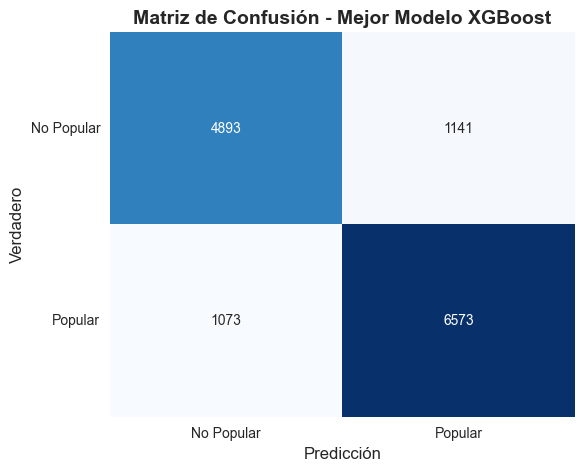

Reporte de Clasificación:
              precision    recall  f1-score   support

  No Popular       0.82      0.81      0.82      6034
     Popular       0.85      0.86      0.86      7646

    accuracy                           0.84     13680
   macro avg       0.84      0.84      0.84     13680
weighted avg       0.84      0.84      0.84     13680



In [15]:
# Diagrama matriz de confusión
print("DIAGRAMA DE MATRIZ DE CONFUSIÓN")
print("=" * 50)
# --- IGNORE ---
y_val_pred = best_model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Mejor Modelo XGBoost', fontsize=14, fontweight='bold')
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Verdadero', fontsize=12)
plt.xticks(ticks=[0.5, 1.5], labels=['No Popular', 'Popular'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Popular', 'Popular'], rotation=0)
plt.show()
# --- IGNORE ---
# Imprimir reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_val, y_val_pred, target_names=['No Popular', 'Popular']))

## 11. Guardar Resultados y Modelos

Guardar el mejor modelo y los resultados de la búsqueda de hiperparámetros.

In [16]:
# Guardar resultados y modelos
print("GUARDANDO RESULTADOS Y MODELOS")
print("=" * 50)

# Crear directorio para resultados
import os
results_dir = '../models/xgboost_classifier_results'
os.makedirs(results_dir, exist_ok=True)

# Guardar el mejor modelo
best_model_path = os.path.join(results_dir, 'best_xgboost_classifier_model.joblib')
joblib.dump(best_model, best_model_path)
print(f"✓ Mejor modelo guardado: {best_model_path}")

# Guardar todos los top 3 modelos
for i, model in enumerate(top_3_models, 1):
    model_path = os.path.join(results_dir, f'top_{i}_model.joblib')
    joblib.dump(model, model_path)
    print(f"✓ Modelo #{i} guardado: {model_path}")

# Guardar resultados de grid search
grid_results_path = os.path.join(results_dir, 'grid_search_results.joblib')
joblib.dump(grid_search, grid_results_path)
print(f"✓ Resultados de Grid Search guardados: {grid_results_path}")

# Guardar métricas en CSV
metrics_path = os.path.join(results_dir, 'model_metrics.csv')
metrics_df.to_csv(metrics_path, index=False)
print(f"✓ Métricas guardadas: {metrics_path}")

# Crear resumen del experimento
experiment_summary = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'algorithm': 'XGBoost Classifier',
    'original_dataset_size': len(X_train_full),
    'training_size': len(X_train),
    'validation_size': len(X_val),
    'features_count': X_train.shape[1],
    'cv_folds': cv_folds,
    'total_combinations_tested': total_combinations,
    'best_params': grid_search.best_params_,
    'best_cv_score': float(grid_search.best_score_),
    'search_duration': str(duration)
}

summary_path = os.path.join(results_dir, 'experiment_summary.json')
import json
with open(summary_path, 'w') as f:
    json.dump(experiment_summary, f, indent=2)
print(f"✓ Resumen del experimento guardado: {summary_path}")

GUARDANDO RESULTADOS Y MODELOS
✓ Mejor modelo guardado: ../models/xgboost_classifier_results/best_xgboost_classifier_model.joblib
✓ Modelo #1 guardado: ../models/xgboost_classifier_results/top_1_model.joblib
✓ Modelo #2 guardado: ../models/xgboost_classifier_results/top_2_model.joblib
✓ Modelo #3 guardado: ../models/xgboost_classifier_results/top_3_model.joblib
✓ Resultados de Grid Search guardados: ../models/xgboost_classifier_results/grid_search_results.joblib
✓ Métricas guardadas: ../models/xgboost_classifier_results/model_metrics.csv
✓ Resumen del experimento guardado: ../models/xgboost_classifier_results/experiment_summary.json


## 12. Resumen Final

Resumen completo del experimento de búsqueda de hiperparámetros.

In [25]:
# Resumen final del experimento
print("🎉 EXPERIMENTO DE BÚSQUEDA DE HIPERPARÁMETROS COMPLETADO")
print("=" * 60)

print(f"📊 ESTADÍSTICAS DEL EXPERIMENTO:")
print(f"  • Algoritmo utilizado: XGBoost Classifier")
print(f"  • Dataset original: {len(X_train_full):,} registros")
print(f"  • Conjunto de entrenamiento: {len(X_train):,} registros")
print(f"  • Conjunto de validación: {len(X_val):,} registros")
print(f"  • Número de características: {X_train.shape[1]}")

print(f"\n🔍 BÚSQUEDA DE HIPERPARÁMETROS:")
print(f"  • Combinaciones evaluadas: {total_combinations:,}")
print(f"  • Folds de validación cruzada: {cv_folds}")
print(f"  • Total de entrenamientos: {total_combinations * cv_folds:,}")
print(f"  • Tiempo total de búsqueda: {duration}")

print(f"\n🏆 MEJORES RESULTADOS:")
print(f"  • Mejores hiperparámetros: {grid_search.best_params_}")
print(f"  • Mejor CV Score (F1): {grid_search.best_score_:.6f}")

# Mostrar las mejores métricas en validación
best_metrics = metrics_results[0]
print(f"\n📈 MÉTRICAS EN VALIDACIÓN (MEJOR MODELO):")
print(f"  • F1 Score: {best_metrics['F1 Score']:.6f}")
print(f"  • ROC AUC: {best_metrics['ROC AUC']:.6f}")
print(f"  • Precision: {best_metrics['Precision']:.6f}")
print(f"  • Recall: {best_metrics['Recall']:.6f}")
print(f"  • Accuracy: {best_metrics['Accuracy']:.6f}")

print(f"\n💾 ARCHIVOS GENERADOS:")
print(f"  • Mejor modelo: {best_model_path}")
print(f"  • Top 3 modelos: {results_dir}/top_*_model.joblib")
print(f"  • Resultados completos: {grid_results_path}")
print(f"  • Métricas: {metrics_path}")
print(f"  • Resumen: {summary_path}")

print(f"\n✅ Experimento completado exitosamente!")
print(f"✅ El modelo está listo para implementación en producción!")

🎉 EXPERIMENTO DE BÚSQUEDA DE HIPERPARÁMETROS COMPLETADO
📊 ESTADÍSTICAS DEL EXPERIMENTO:
  • Algoritmo utilizado: XGBoost Classifier
  • Dataset original: 91,199 registros
  • Conjunto de entrenamiento: 77,519 registros
  • Conjunto de validación: 13,680 registros
  • Número de características: 18

🔍 BÚSQUEDA DE HIPERPARÁMETROS:
  • Combinaciones evaluadas: 1,296
  • Folds de validación cruzada: 5
  • Total de entrenamientos: 6,480
  • Tiempo total de búsqueda: 0:14:06.071128

🏆 MEJORES RESULTADOS:
  • Mejores hiperparámetros: {'colsample_bytree': 0.6, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}
  • Mejor CV Score (F1): 0.854243

📈 MÉTRICAS EN VALIDACIÓN (MEJOR MODELO):
  • F1 Score: 0.855859
  • ROC AUC: 0.835285
  • Precision: 0.852087
  • Recall: 0.859665
  • Accuracy: 0.838158

💾 ARCHIVOS GENERADOS:
  • Mejor modelo: ../models/xgboost_classifier_results/best_xgboost_classifier_model.joblib
  • Top 3 modelos: ../models/xgboost_c

In [24]:
import mlflow

mlflow.set_tracking_uri("http://54.167.36.129:8050")
experiment = mlflow.set_experiment("XGBoost_Binary_Classifier_Experiment")
# Iniciar una nueva ejecución de MLflow
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="XGBoost Top 3 Models Metrics"):
  for i, metrics in enumerate(metrics_results, 0):
    with mlflow.start_run(nested=True, run_name=f"Model_{i+1}"):
      # Registrar los parámetros del modelo
      mlflow.log_params(top_3_params[i])
      # Registrar las métricas principales
      mlflow.log_metric(f"Precision", metrics['Precision'])
      mlflow.log_metric(f"Recall", metrics['Recall'])
      mlflow.log_metric(f"F1_Score", metrics['F1 Score'])
      mlflow.log_metric(f"ROC_AUC", metrics['ROC AUC'])
      mlflow.log_metric(f"Accuracy", metrics['Accuracy'])
      # Registrar el modelo
      mlflow.sklearn.log_model(top_3_models[i], input_example=X_val.iloc[[0]])
  print("✓ Métricas de los top 3 modelos registradas en MLflow")

🏃 View run Model_1 at: http://54.167.36.129:8050/#/experiments/860589367715753702/runs/42a051ffaa5345abb842d7a99cd5e1e9
🧪 View experiment at: http://54.167.36.129:8050/#/experiments/860589367715753702
🏃 View run Model_2 at: http://54.167.36.129:8050/#/experiments/860589367715753702/runs/451981546d38484ca926732577debd58
🧪 View experiment at: http://54.167.36.129:8050/#/experiments/860589367715753702
🏃 View run Model_3 at: http://54.167.36.129:8050/#/experiments/860589367715753702/runs/0f2f156dffad405281dfa244622670f9
🧪 View experiment at: http://54.167.36.129:8050/#/experiments/860589367715753702
✓ Métricas de los top 3 modelos registradas en MLflow
🏃 View run XGBoost Top 3 Models Metrics at: http://54.167.36.129:8050/#/experiments/860589367715753702/runs/962e2843ca76450e8ea790c7b0a04eab
🧪 View experiment at: http://54.167.36.129:8050/#/experiments/860589367715753702
